In [2]:
# Threading
# To start Julia with 8 threads on PC, open anaconda prompt and run <set JULIA_NUM_THREADS=8>, then run <jupyter notebook>
# ENV["JULIA_NUM_THREADS"] = 8 # Don't need to run on mac - set nthreads in VScode
Threads.nthreads()

8

In [3]:
# import Pkg; Pkg.develop(path="/Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl")
using IRQIV
import PyPlot as plt
import Statistics, NaNStatistics
plt.pygui(true) # sets plots to popup instead of inline

true

In [4]:
# Import images using IRQIV

FLIR_filename = joinpath(raw"/Volumes/ETH_4TB/CNRD_IR/Rec-DeFreesLab_-003504.ats")
# FLIR_filename = joinpath(raw"D:\CNRD_IR\Rec-DeFreesLab_-003504.ats")
Img_dims = [784, 1344]
DtFrames = 1
nImagePairs = Inf

# set range to average over and load images
# inds = range(1, step=1, length=500)
# raw_imgs_ds = LoadATSImageSequence(FLIR_filename, inds, 2022)

Inf

In [5]:
# Global camera parameters
fl = 1214.2857142857144 # In pixels - from Seth
include(raw"/Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/examples/CameraCalibrationHelpers.jl")
Camera = IRQIV.FLIR_SC8303_17mm
ι = IRQIV.IntrinsicCalibrationParameters(Camera)

IntrinsicCalibrationParameters(672.5, 392.5, 1.0086485610865155, 1.0, 1.4e-5, [1.0, 3.0, 5.0], [0.020522291524825344, -3.156396095419575e-8, -8.859823756718999e-14])

┌ Warning: thread = 1 warning: parsed expected 6 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV /Users/evanheberlein/.julia/packages/CSV/OnldF/src/file.jl:578


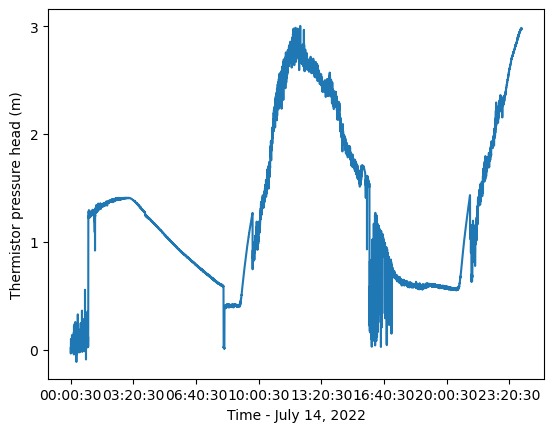

In [6]:
# INCORPORATE GEOREFERENCING - bay side
import CSV, Dates, Geodesy
using DataFrames
ft_to_m = 0.3048

# Import dike resurvey data from May 2023
macpath = raw"/Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/CACO/2023/5_23_SiteVisit/Georeferencing/Leica/M_CNRD.TXT"
winpath = raw"C:\Users\evanh\Box\Cornell\CACO\2023\5_23_SiteVisit\Georeferencing\Leica\M_CNRD.TXT"
ft_to_m = 0.3048
CNRD_resurvey = CSV.read(macpath, DataFrames.DataFrame) # Total station recorded in survey ft!!
US_GCP_xyz_resurvey = [CNRD_resurvey[2:7,2] CNRD_resurvey[2:7,3] CNRD_resurvey[2:7,4]] .* ft_to_m
DS_GCP_xyz_resurvey = [CNRD_resurvey[8:12,2] CNRD_resurvey[8:12,3] CNRD_resurvey[8:12,4]] .* ft_to_m

# Convert to geospatial coords using GPS data
antenna_csv = CSV.read(raw"/Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/CACO/2023/5_23_SiteVisit/Georeferencing/InertialSense/20230515_173251_base/LOG_SN40107_20230515_173251_0001_DID_GPS1_RTK_POS.csv", DataFrames.DataFrame)
antenna_lla = Geodesy.LLA(Statistics.mean(antenna_csv."lla[0]"), Statistics.mean(antenna_csv."lla[1]"), Statistics.mean(antenna_csv."lla[2]"))
antenna_utm = Geodesy.UTMZ(antenna_lla, Geodesy.wgs84)

# US_GCP_utm_resurvey = US_GCP_xyz_resurvey + [antenna_utm.x antenna_utm.y antenna_utm.z]
US_GCP_utm_resurvey = US_GCP_xyz_resurvey .+ [antenna_utm.x antenna_utm.y antenna_utm.z] # Add UTM position of antenna to all relative points in m
DS_GCP_utm_resurvey = DS_GCP_xyz_resurvey .+ [antenna_utm.x antenna_utm.y antenna_utm.z] # Add UTM position of antenna to all relative points in m

# Set x&y location of all bolts on post 5 to same location (vertically-aligned)
# DS_GCP_utm_resurvey[2, 1:2] = DS_GCP_utm_resurvey[1, 1:2]
# DS_GCP_utm_resurvey[3, 1:2] = DS_GCP_utm_resurvey[1, 1:2]
US_GCP_utm_resurvey

# Import thermistor data from field campaign

# ChatGPT function to find nearest thermistor times to each ATS file (for WSE)
function find_nearest_time_indices(irregular_times, regular_times)
    nearest_indices = [argmin(abs.(time .- regular_times)) for time in irregular_times]
    return nearest_indices
end

thermpath = raw"/Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/CACO/2022/Thermistor/P6_CACO_July_2022_truncated.txt"
therm = CSV.read(thermpath, delim = ',', DataFrame)
thermP = therm[:,2] # water surface elevation from thermistor - in dbar?
# # 360 lines per hour, 8640 lines per day
us_therm_cam_offset = (sqrt(9^2-2^2) + 1/3 + 7) * ft_to_m
ds_therm_cam_offset = 209/12*ft_to_m

therm[!,3] = Dates.Date.(therm[!,3], " dd u YYYY")
therm_datetime = Dates.DateTime.(therm[!,3], therm[!,4])
therm = hcat(therm, therm_datetime)
rename!(therm,[:TemperatureC, :PressureM, :Date, :Time, :DateTime])

therm_moved_bool = (therm.Time .== Dates.Time("08:12:00", "HH:MM:SS")) .& (therm.Date .== Dates.Date("2022-07-14", "yyyy-mm-dd"))
therm_moved_idx = findall(x->x==1, therm_moved_bool)
thermZ = us_therm_cam_offset.-thermP[1:therm_moved_idx[]] # vertical offset from camera to thermistor - 
thermZ = append!(thermZ, ds_therm_cam_offset.-thermP[therm_moved_idx[]+1:end])

therm = hcat(therm, thermZ)
rename!(therm, :x1 => :WaterDistanceFromCameraM)

plt.close("all")
thermT = string.(therm[:,4])
plt.plot(thermT[6302:6302+8638], thermP[6302:6302+8638])
plt.xticks(1:1200:length(thermZ[6302:6302+8638])#, rotation = 45
)
plt.xlabel("Time - July 14, 2022")
plt.ylabel("Thermistor pressure head (m)")
plt.rc("font",size=24)
plt.gcf()

In [66]:
import Geodesy

# Incorporate board georef on bay side:
DS_board_o1 = CSV.read(raw"/Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/CACO/2022/CACO_GPS/20220714_201935_DS_GCPo1/LOG_SN40107_20220714_201935_0001_DID_GPS1_POS.csv", DataFrame)
DS_board_o1 = DS_board_o1[:,[9, 10, 11, 16]] # lla 1-3 + status (code 0x00000C00 = RTK_FIX according to pg. 138: https://docs.inertialsense.com/user-manual/reference/user_manual_pdf/InertialSenseDocs.pdf)
DS_board_o1_fix = filter(row->any(occursin.("C", row.status[end-2:end-2])), DS_board_o1) # from https://discourse.julialang.org/t/better-way-to-filter-strings-from-dataframe/88012
DS_board_o4 = CSV.read(raw"/Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/CACO/2022/CACO_GPS/20220714_210002_DS_GCPo4/LOG_SN40107_20220714_210002_0001_DID_GPS1_POS.csv", DataFrame)
DS_board_o4 = DS_board_o4[:,[9, 10, 11, 16]] 
DS_board_o4_fix = filter(row->any(occursin.("C", row.status[end-2:end-2])), DS_board_o4) 
DS_board_o5 = CSV.read(raw"/Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/CACO/2022/CACO_GPS/20220714_211156_DS_GCPo5/LOG_SN40107_20220714_211156_0001_DID_GPS1_POS.csv", DataFrame)
DS_board_o5 = DS_board_o5[:,[9, 10, 11, 16]] 
DS_board_o5_fix = filter(row->any(occursin.("C", row.status[end-2:end-2])), DS_board_o5) 

# o4 & o5 did not get to RTK_FIX but still look very steady - average!
# plt.close("all")
# plt.plot(DS_board_o1_fix[:,1])
# #plt.plot(DS_board_o1_fix[:,2])
# plt.plot(DS_board_o4[:,1])
# #plt.plot(DS_board_o4[:,2])
# #plt.plot(DS_board_o4[:,3])
# plt.plot(DS_board_o5[:,1])
# #plt.plot(DS_board_o5[:,2])
# #plt.plot(DS_board_o5[:,3])

# Check drift of non-fix GPS 
maximum(DS_board_o4[:,1]) - minimum(DS_board_o4[:,1])
maximum(DS_board_o4[:,2]) - minimum(DS_board_o4[:,2])
maximum(DS_board_o4[:,3]) - minimum(DS_board_o4[:,3])
maximum(DS_board_o5[:,1]) - minimum(DS_board_o5[:,1])
maximum(DS_board_o5[:,2]) - minimum(DS_board_o5[:,2])
maximum(DS_board_o5[:,3]) - minimum(DS_board_o5[:,3])
# Drift is minimal in x/y but large in z

# Compare averages/minimums
DS_board_o1_avg = Statistics.mean.(eachcol(DS_board_o1_fix[:,1:3])) # Only fix GPS data used for x-y coords
DS_board_o4_avg = Statistics.mean.(eachcol(DS_board_o4[:,1:3]))
DS_board_o5_avg = Statistics.mean.(eachcol(DS_board_o5[:,1:3]))
DS_board_o5_avg[3] = minimum(DS_board_o5[:,3])
# dump(DS_board_o1_avg[3])
# dump(DS_board_o4_avg[3])
# dump(DS_board_o5_avg[3])
# o5 minimum is closer to mean of o1 & o4, numbers look reasonable relative to DS_GCP_utm_resurvey

# Convert LLA to UTM
DS_board_o1_utm = Geodesy.UTMZ(Geodesy.LLA(DS_board_o1_avg[1], DS_board_o1_avg[2], DS_board_o1_avg[3]), Geodesy.wgs84)
DS_board_o4_utm = Geodesy.UTMZ(Geodesy.LLA(DS_board_o4_avg[1], DS_board_o4_avg[2], DS_board_o4_avg[3]), Geodesy.wgs84)
DS_board_o5_utm = Geodesy.UTMZ(Geodesy.LLA(DS_board_o5_avg[1], DS_board_o5_avg[2], DS_board_o5_avg[3]), Geodesy.wgs84)
DS_board_utm = [DS_board_o1_utm.x DS_board_o1_utm.y DS_board_o1_utm.z
DS_board_o4_utm.x DS_board_o4_utm.y DS_board_o1_utm.z
DS_board_o5_utm.x DS_board_o5_utm.y DS_board_o1_utm.z]

# Add board GPS (first orientation only) to resurvey vector:
DS_GCP_utm_combined = vcat(DS_GCP_utm_resurvey, DS_board_utm[1,:]')

plt.plot(DS_board_o1_fix[:,3])
plt.gcf()

# Georeferencing very sensitive to board z-coordinate, select from antenna time series to improve reprojection:
DS_GCP_utm_combined[6,3] = minimum(DS_board_o1[:,3]) # Can tweak this up to +>1m to adjust extent of FOV outward from dike
DS_GCP_utm_combined




6×3 Matrix{Float64}:
      4.11745e5  4.64267e6  -25.1365
      4.11745e5  4.64267e6  -25.5898
      4.11745e5  4.64267e6  -26.0746
      4.11744e5  4.64268e6  -26.2701
 411744.0        4.64268e6  -27.268
      4.11743e5  4.64267e6  -27.716

In [60]:
# Camera location calibration setup - BAY SIDE:
camll_ds = [41.931099, -70.064524] # Guess from Google maps
# Have measurement of camera to deck (?) for US side
camelev_ds = DS_GCP_utm_resurvey[3,3] + 6.5*ft_to_m # Use lower bolt elevation w/ offset - [old: Guess DS camera offset from board GCP elev based on photos]
cam_LLA_ds = Geodesy.LLA(camll_ds[1], camll_ds[2], camelev_ds)
cam_UTM_ds = Geodesy.UTMZ(cam_LLA_ds, Geodesy.wgs84)

# # Camera angle approximation:
# azimuth_ds = 315 * (pi/180)  # Guess from google maps
# tilt_ds = atan(34/120) # atan(120/34)  # Approx. from photo
# roll_ds = atan(7/50) # ''
# azimuth_ds = 315 * (pi/180)  # Guess from google maps
azimuth_ds = deg2rad(315-360) # updated 12/3/24
# tilt_ds = atan(34/120) # atan(120/34)  # Approx. from photo
tilt_ds = -pi + atan(34/120) # updated 12/3/24 - negative from vertical
roll_ds = atan(7/50) # ''

# Initial guess of camera's extrinsic parameters:
χinitial_ds = IRQIV.ExtrinsicCalibrationParameters(azimuth_ds, tilt_ds, roll_ds, fl, cam_UTM_ds.x, cam_UTM_ds.y, cam_UTM_ds.z)
dump(χinitial_ds)

# UTM coordinates of GCPs:
# TrueGCPxyz = [GCPxyz_us[:,1] GCPxyz_us[:,2] GCPzg_us]

# Pixel coordinates of GCPs, before accounting for radial distortion:
# File 3582 can see bolt without grass in the way
DistortedImageGCPuv_ds  = [1255 443 # 5H
                        1200 549 # 5M
                        1155 615 # 5L
                        1257 73 # 6H
                        1278 264 # 6L
                        606 71] # board o1
                        # 516 366 # board o4
                        # 388 716] # board o5


TrueGCPuv_ds = hcat(IRQIV.RemoveRadialDistortion(DistortedImageGCPuv_ds[:,1], DistortedImageGCPuv_ds[:,2], Camera)...)

FLIR_filename_ds = joinpath(raw"/Volumes/ETH_4TB/CNRD_IR/Rec-DeFreesLab_-003482.ats")
IRimages_ds = LoadATSImageSequence(FLIR_filename_ds, 1, 2022)
plt.close("all")
plt.rc("font", size=8)
GraphicallyExploreInitialCalibrationGuess(TrueGCPuv_ds, DS_GCP_utm_combined, χinitial_ds, ι, IRimages_ds[1])
# plt.gcf()

ExtrinsicCalibrationParameters
  φ: Float64 -0.7853981633974483
  τ: Float64 -2.8654956341943567
  σ: Float64 0.13909594148207133
  f: Float64 1214.2857142857144
  x_c: Float64 411743.0601037771
  y_c: Float64 4.642674180709229e6
  z_c: Float64 -24.093384677637545


┌ Warning: Too few BHPHeaders to calculate fps!
└ @ IRQIV.FLIRATSFiles /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/src/FLIRATSFiles.jl:415
┌ Info: (411744.63910856453, 411743.2911857274)
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/examples/CameraCalibrationHelpers.jl:68
┌ Info: (411744.62618504453, 411743.4029594806)
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/examples/CameraCalibrationHelpers.jl:68
┌ Info: (411744.63673112454, 411743.50989988155)
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/examples/CameraCalibrationHelpers.jl:68
┌ Info: (411743.92697384453, 411743.17484681663)
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/examples/CameraCalibrationHelpers.jl:68
┌ Info: (411744.04889384453, 411743.5643500467)
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/examples/CameraCalibrationHelpers.jl:68
┌ Info: (411742.

PyObject Text(0.5, 0.98, 'red is calculated, black is provided\n\nExtrinsicCalibrationParameters\n  φ: Float64 -0.785398\n  τ: Float64 -2.8655\n  σ: Float64 0.139096\n  f: Float64 1214.29\n  x_c: Float64 4.11743e5\n  y_c: Float64 4.64267e6\n  z_c: Float64 -24.0934\n')

Finished extrinsic calibration:, 18 iterations, max(|ε|)=1e-10, rms(ε₁-ε₀)=2e-11
ExtrinsicCalibrationParameters
  φ: Float64 -0.7853981633974483
  τ: Float64 -2.8654956341943567
  σ: Float64 0.13909594148207133
  f: Float64 1214.2857142857144
  x_c: Float64 411743.0601037771
  y_c: Float64 4.642674180709229e6
  z_c: Float64 -24.093384677637545
dump(χinitial_ds) = nothing
ExtrinsicCalibrationParameters
  φ: Float64 -1.4304548190321396
  τ: Float64 -2.821451967980822
  σ: Float64 0.38292668649731326
  f: Float64 1280.579618118304
  x_c: Float64 411744.6774145493
  y_c: Float64 4.642674015771329e6
  z_c: Float64 -23.93024861855872
dump(χcalculated_ds) = nothing


┌ Info: Initial guess, χinitial:
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/CACO/CACO_git/CACO_22_jl/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X13sZmlsZQ==.jl:14
┌ Info: Calibrated values, χcalculated:
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/CACO/CACO_git/CACO_22_jl/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X13sZmlsZQ==.jl:17
┌ Info: Difference between calibrated value and initial guess:
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/CACO/CACO_git/CACO_22_jl/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X13sZmlsZQ==.jl:21


φ diff (degrees) -  36.95902391469154
τ diff (degrees) -  -2.5235161883184856
σ diff (degrees) -  -13.970472604903899
f diff -  -66.29390383258965
x_c diff (meters) -  -1.6173107721842825
y_c diff (meters) -  0.16493789944797754
z_c diff (meters) -  -0.16313605907882334
  0.000076 seconds (1.72 k allocations: 174.438 KiB)


┌ Info: (411744.63910856453, 411744.61052058137)
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/examples/CameraCalibrationHelpers.jl:68
┌ Info: (411744.62618504453, 411744.66087158065)
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/examples/CameraCalibrationHelpers.jl:68
┌ Info: (411744.63673112454, 411744.7066817419)
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/examples/CameraCalibrationHelpers.jl:68
┌ Info: (411743.92697384453, 411743.94263306085)
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/examples/CameraCalibrationHelpers.jl:68
┌ Info: (411744.04889384453, 411744.1250520601)
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/examples/CameraCalibrationHelpers.jl:68
┌ Info: (411742.5946517856, 411742.3464174061)
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/examples/CameraCalibrationHelpers.jl:68
┌ Info: (1255.

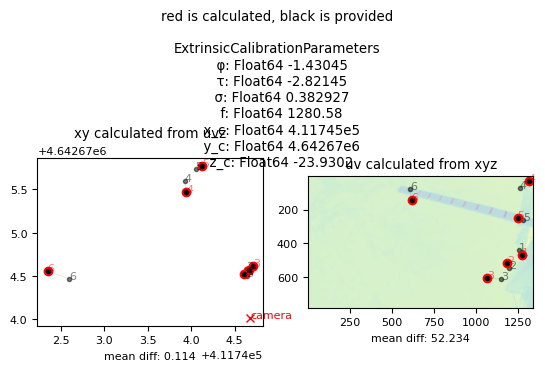

In [68]:
# Camera location calibration - BAY SIDE:
dlt_ds = IRQIV.DLT(χinitial_ds, FLIR_SC8303_17mm)
###############################################################################

χcalculated_ds = ExtrinsicCalibration(
    TrueGCPuv_ds,
    DS_GCP_utm_combined,
    χinitial_ds,
    ι,
    MaxIterations = 50,
    PrintoutStats=true)

# ###############################################################################
@info "Initial guess, χinitial:"
@show dump(χinitial_ds)
# 
@info "Calibrated values, χcalculated:"
@show dump(χcalculated_ds)
# 
# Describe how much the calibration changed each parameter:
@info "Difference between calibrated value and initial guess:"
for (i,x) in enumerate(fieldnames(typeof(χcalculated_ds)))
    if i <= 3
        println("$x diff (degrees) -  $(rad2deg(getfield(χinitial_ds, x) - getfield(χcalculated_ds, x)))")
    elseif i == 4
        println("$x diff -  $(getfield(χinitial_ds, x) - getfield(χcalculated_ds, x))")
    else
        println("$x diff (meters) -  $(getfield(χinitial_ds, x) - getfield(χcalculated_ds, x))")
    end
end

# Extract WSE from thermistor time series using ATS file timestamp
ATS_file_time_ds = IRQIV.ats_ts(IRimages_ds)
therminds_ds = find_nearest_time_indices(ATS_file_time_ds, therm.DateTime)
WSE_mean_ATS_ds = χcalculated_ds.z_c - therm.WaterDistanceFromCameraM[therminds_ds][1]
RectParams_ds = IRQIV.ImageRectification.calculate_image_rectification(Camera.pixel_resolution, ι, χcalculated_ds, WSE_mean_ATS_ds, interpolated_grid_spacing=.1)
rectified_image_ds = RectParams_ds(IRimages_ds)

plt.close("all")
plt.rc("font", size=8)
GraphicallyExploreInitialCalibrationGuess(TrueGCPuv_ds, DS_GCP_utm_combined, χcalculated_ds, ι, IRimages_ds[1])
plt.gcf()



Geotransform: [411731.1838, 0.15015076923076637, 0.0, 4.6426986079e6, 0.0, -0.14986969697091615]
Projection: PROJCS["NAD83(2011) / UTM zone 19N",GEOGCS["NAD83(2011)",DATUM["NAD83_National_Spatial_Reference_System_2011",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","1116"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","6318"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-69],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","6348"]]


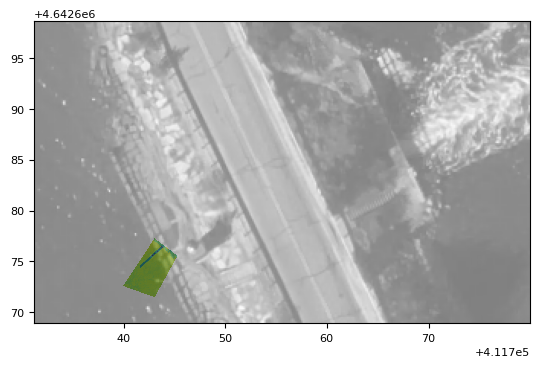

In [69]:
# Test reprojection against basemap imagery

import ArchGDAL
basemap_path = ArchGDAL.read(raw"/Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/CACO/2022/Analysis/ESRI_basemap/ESRI_basemap.tif")
basemap_band = ArchGDAL.getband(basemap_path, 1)
basemap = ArchGDAL.read(basemap_band)
# basemap = reverse(reverse(basemap, dims=1), dims=2)
basemap = permutedims(basemap, (2, 1))
# basemap = reverse(reverse(basemap, dims=2))

# Get the geotransform (affine transformation to map pixel coordinates to world coordinates)
geotransform = ArchGDAL.getgeotransform(basemap_path)

# Get the dimensions of the image
width = ArchGDAL.width(basemap_path)
height = ArchGDAL.height(basemap_path)

# Extract the geotransform values
x_min = geotransform[1]
y_max = geotransform[4]
x_res = geotransform[2]  # Pixel width
y_res = geotransform[6]  # Pixel height (negative)

# Calculate the extents
x_max = x_min + size(basemap, 2) * x_res
y_min = y_max + size(basemap, 1) * y_res

# Extent for imshow
basemap_extent = (x_min, x_max, y_min, y_max)

# Get the projection (coordinate system)
projection = ArchGDAL.getproj(basemap_path)

println("Geotransform: ", geotransform)
println("Projection: ", projection)

plt.close("all")
plt.imshow(rectified_image_ds, extent=RectParams_ds.extent)
plt.imshow(basemap, extent=basemap_extent, alpha = 0.5, cmap = "gray")
plt.gcf()

┌ Warning: Too few BHPHeaders to calculate fps!
└ @ IRQIV.FLIRATSFiles /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/src/FLIRATSFiles.jl:415
┌ Warning: Too few BHPHeaders to calculate fps!
└ @ IRQIV.FLIRATSFiles /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/src/FLIRATSFiles.jl:415
┌ Info: (411768.0031563245, 411770.4443634363)
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/examples/CameraCalibrationHelpers.jl:68
┌ Info: (411767.9834967245, 411770.2188593963)
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/examples/CameraCalibrationHelpers.jl:68
┌ Info: (411767.55823976453, 411769.8969740929)
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/examples/CameraCalibrationHelpers.jl:68
┌ Info: (411767.4251945645, 411769.8061492483)
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/examples/CameraCalibrationHelpers.jl:68
┌ Info: (411766.9903059

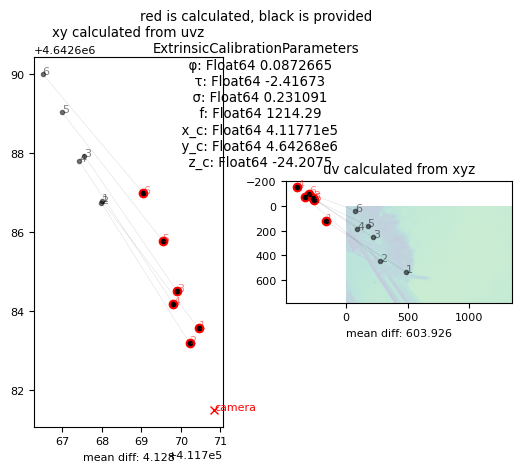

In [12]:
# Camera location calibration setup - RIVER SIDE:
camll_us = [41.931168, -70.064190] # Guess from google maps
camelev_us = sqrt(9^2-2^2)*ft_to_m + (US_GCP_utm_resurvey[1,3]) # add elevation from bridge deck to elevation of first bolt below deck (~4" off?), remove second ft_to_m 12/3/24
cam_LLA_us = Geodesy.LLA(camll_us[1], camll_us[2], camelev_us)
cam_UTM_us = Geodesy.UTMZ(cam_LLA_us, Geodesy.wgs84)

# Camera angle approximation:
azimuth_us = deg2rad(5) # Guess from google maps
# azimuth_us = deg2rad(5-40) # CONVERGE #1
# tilt_us = atan(70/62) # Approx. from photo
# tilt_us = atan(70/62 - deg2rad(55)) # CONVERGE #1
tilt_us = -pi/2 - atan(70/62) # updated 12/3/24 - negative from vertical
roll_us = atan(20/85) # Approx. from photo
# roll_us = atan(20/85 + deg2rad(45)) # CONVERGE #1

# Initial guess of camera's extrinsic parameters:
χinitial_us = IRQIV.ExtrinsicCalibrationParameters(azimuth_us, tilt_us, roll_us, fl, cam_UTM_us.x, cam_UTM_us.y, cam_UTM_us.z) # can also play with height
# χinitial = IRQIV.ExtrinsicCalibrationParameters(azimuth_us, tilt_us, roll_us, fl, cam_UTM_us.x-1, cam_UTM_us.y+2, cam_UTM_us.z) # CONVERGE #1

# UTM coordinates of GCPs:
# TrueGCPxyz = [GCPxyz_us[:,1] GCPxyz_us[:,2] GCPzg_us]

# Pixel coordinates of GCPs, before accounting for radial distortion:
DistortedImageGCPuv_us  = [481 535 # 1L
                        270 446 # 1H
                        215 253 # 2L
                        94 188 # 2H
                        174 159 # 3
                        83 43] # 4
                        #474 65] # board o1

## Remove radial distortion from GCP target coordinates:
TrueGCPuv_us = hcat(IRQIV.RemoveRadialDistortion(DistortedImageGCPuv_us[:,1], DistortedImageGCPuv_us[:,2], Camera)...)

# Optionally, load an IR image and plot it in the background:
FLIR_filename_us = raw"/Volumes/ETH_4TB/CNRD_IR/Rec-DeFreesLab_-003310.ats"
IRimages_us = LoadATSImageSequence(FLIR_filename_us, 1, 2022)
plt.close("all")
GraphicallyExploreInitialCalibrationGuess(TrueGCPuv_us, US_GCP_utm_resurvey, χinitial_us, ι, IRimages_us[1])
plt.gcf()

Finished extrinsic calibration:, 16 iterations, max(|ε|)=5e-10, rms(ε₁-ε₀)=6e-11
ExtrinsicCalibrationParameters
  φ: Float64 0.08726646259971647
  τ: Float64 -2.416726509974452
  σ: Float64 0.23109066719589708
  f: Float64 1214.2857142857144
  x_c: Float64 411770.8466259552
  y_c: Float64 4.6426814979640795e6
  z_c: Float64 -24.207543132360424
dump(χinitial_us) = nothing
ExtrinsicCalibrationParameters
  φ: Float64 -0.20482039987361095
  τ: Float64 -2.663588777346602
  σ: Float64 0.5576101617172943
  f: Float64 921.7624007662248
  x_c: Float64 411769.0569816039
  y_c: Float64 4.642685635728899e6
  z_c: Float64 -24.21088685609575
dump(χcalculated_us) = nothing


┌ Info: Initial guess, χinitial:
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/CACO/CACO_git/CACO_22_jl/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X16sZmlsZQ==.jl:15
┌ Info: Calibrated values, χcalculated:
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/CACO/CACO_git/CACO_22_jl/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X16sZmlsZQ==.jl:18
┌ Info: Difference between calibrated value and initial guess:
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/CACO/CACO_git/CACO_22_jl/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X16sZmlsZQ==.jl:22


φ diff (degrees) -  16.73534447093977
τ diff (degrees) -  14.144166041454277
σ diff (degrees) -  -18.708188964821062
f diff -  292.52331351948965
x_c diff (meters) -  1.7896443512872793
y_c diff (meters) -  -4.137764819897711
z_c diff (meters) -  0.0033437237353268756
  0.000188 seconds (3.83 k allocations: 389.375 KiB)


┌ Info: (411768.0031563245, 411768.06524219736)
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/examples/CameraCalibrationHelpers.jl:68
┌ Info: (411767.9834967245, 411767.9677770917)
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/examples/CameraCalibrationHelpers.jl:68
┌ Info: (411767.55823976453, 411767.515936227)
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/examples/CameraCalibrationHelpers.jl:68
┌ Info: (411767.4251945645, 411767.5068939898)
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/examples/CameraCalibrationHelpers.jl:68
┌ Info: (411766.9903059245, 411767.0305664914)
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/examples/CameraCalibrationHelpers.jl:68
┌ Info: (411766.4980234445, 411766.4979707668)
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/examples/CameraCalibrationHelpers.jl:68
┌ Info: (484.53052958

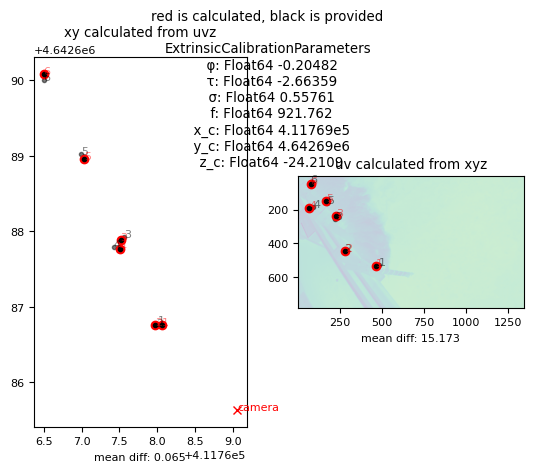

In [13]:
# Camera location calibration - RIVER SIDE:
dlt_us = IRQIV.DLT(χinitial_us, FLIR_SC8303_17mm)
###############################################################################

TrueGCPxyz_us = US_GCP_utm_resurvey # US_GCP_utm_combined

χcalculated_us = ExtrinsicCalibration(
    TrueGCPuv_us,
    TrueGCPxyz_us,
    χinitial_us,
    ι,
    MaxIterations = 50,
    PrintoutStats=true)
# ###############################################################################
@info "Initial guess, χinitial:"
@show dump(χinitial_us)
# 
@info "Calibrated values, χcalculated:"
@show dump(χcalculated_us)
# 
# Describe how much the calibration changed each parameter:
@info "Difference between calibrated value and initial guess:"
for (i,x) in enumerate(fieldnames(typeof(χcalculated_us)))
    if i <= 3
        println("$x diff (degrees) -  $(rad2deg(getfield(χinitial_us, x) - getfield(χcalculated_us, x)))")
    elseif i == 4
        println("$x diff -  $(getfield(χinitial_us, x) - getfield(χcalculated_us, x))")
    else
        println("$x diff (meters) -  $(getfield(χinitial_us, x) - getfield(χcalculated_us, x))")
    end
end

# Extract WSE from thermistor time series using ATS file timestamp
ATS_file_time_us = IRQIV.ats_ts(IRimages_us)
therminds_us = find_nearest_time_indices(ATS_file_time_us, therm.DateTime)
WSE_mean_ATS_us = χcalculated_us.z_c - therm.WaterDistanceFromCameraM[therminds_us][1]
RectParams_us = IRQIV.ImageRectification.calculate_image_rectification(Camera.pixel_resolution, ι, χcalculated_us, WSE_mean_ATS_us, interpolated_grid_spacing=0.1)
rectified_image_us = RectParams_us(IRimages_us)

plt.close("all")
plt.rc("font", size=8)
GraphicallyExploreInitialCalibrationGuess(TrueGCPuv_us, TrueGCPxyz_us, χcalculated_us, ι, IRimages_us[1])
plt.gcf()

In [14]:
dump(RectParams_ds.extent)

Array{Float64}((4,)) [411739.87321049755, 411745.4732104975, 4.642671304459055e6, 4.642677304459055e6]


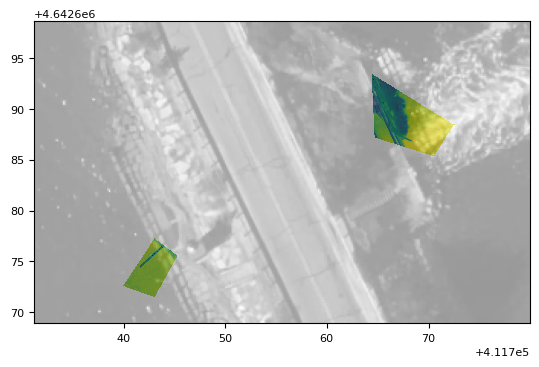

In [70]:
# Plot both sides FOV on basemap imagery

plt.close("all")
plt.imshow(rectified_image_us, extent=RectParams_us.extent)
plt.imshow(rectified_image_ds, extent=RectParams_ds.extent)
plt.imshow(basemap, extent=basemap_extent, alpha = 0.4, cmap = "gray")
plt.gcf()

In [17]:
# Check relative dimensions of FOVs - upstream should cover roughly 3x the area of downstream (3 gates vs 1)

bayside_top_x, bayside_top_y = 411743.45, 4642676.59
bayside_right_x, bayside_right_y = 411745.29, 4642675.22
bayside_dist = sqrt((bayside_right_x - bayside_top_x)^2 + (bayside_right_y - bayside_top_y)^2)
riverside_top_x, riverside_top_y = 411764.97, 4642692.52
riverside_bottom_x, riverside_bottom_y = 411767.98, 4642686.07
riverside_dist = sqrt((riverside_top_x - riverside_bottom_x)^2 + (riverside_top_y - riverside_bottom_y)^2)
riverside_dist / bayside_dist
# bayside_dist

3.102756417287206